# All-probe Bombcell dashboard (ROI-aware)

This notebook loads **all probes simultaneously** and builds ROI-aware tables/plots.

## How to use `IN_ROI` / `OUTSIDE_ROI`
1. Set per-probe ROI length in `ROI_END_UM_BY_PROBE` (distance from probe tip in microns).
2. Units with `distance_from_tip_um <= ROI_END_UM_BY_PROBE[probe]` are labeled `IN_ROI`.
3. Units above that cutoff are labeled `OUTSIDE_ROI`.
4. If a probe has no ROI value (`None`), units are labeled `ROI_NOT_SET`.


In [23]:
import sys
from pathlib import Path
sys.path.insert(0, str((Path.cwd() / '..' / '..').resolve()))

from grant.grant_config import load_grant_config

CONFIG_FILE = 'C:\\Users\\user\\Documents\\github\\bombcell\\py_bombcell\\grant\\configs\\grant_recording_config_reach15_20260201_session007.json'
RUN_MODE = 'batch'  # batch | np20_rerun | single_probe
TARGET_PROBE = 'B'  # only used for single_probe

cfg = load_grant_config(CONFIG_FILE)
print('Loaded config:', cfg['config_path'])
print('Recording:', cfg['recording_name'])
print('Target probe:', TARGET_PROBE)
print('Run mode:', RUN_MODE)


Loaded config: C:\Users\user\Documents\github\bombcell\py_bombcell\grant\configs\grant_recording_config_reach15_20260201_session007.json
Recording: Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00
Target probe: B
Run mode: batch


In [24]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bombcell as bc

analysis_dir = Path.cwd().resolve()
sys.path.insert(0, str(analysis_dir))
from post_analysis_setup import load_post_analysis_context, label_units_by_tip_distance

CONFIG_FILE = 'C:\\Users\\user\\Documents\\github\\bombcell\\py_bombcell\\grant\\configs\\grant_recording_config_reach15_20260201_session007.json'
RUN_MODE = 'batch'  # batch | np20_rerun | single_probe

# IMPORTANT: set your per-probe ROI extents from TIP (um)
# Example from issue: Probe B NP1.0 ROI is tip->950um
# EVERY PROBE INCLUDES ~200um PADDING BEYOND ROI END
ROI_END_UM_BY_PROBE = {
    'A': 3450, # 3250um + 200um padding 
    'B': 950, # 750um + 200um padding
    'C': 1800, # 1600um + 200um padding
    'D': 1400, # 1200um + 200um padding
    'E': 800, # 600um + 200um padding
    'F': 1120, # 920um + 200um padding
}
TIP_POSITION_BY_PROBE = {
    'A': 'min_y', 'B': 'min_y', 'C': 'min_y',
    'D': 'min_y', 'E': 'min_y', 'F': 'min_y',
}


In [25]:
ctx = load_post_analysis_context(CONFIG_FILE)
mode_to_roots = {
    'batch': ctx['DEFAULT_KS_STAGING_ROOT'],
    'np20_rerun': ctx['NP20_KS_STAGING_ROOT'],
    'single_probe': ctx['BOMBCELL_KS_SINGLEPROBE_STAGING_ROOT'],
}
staging_root = mode_to_roots[RUN_MODE]
probe_letters = list(ctx['probeLetters'])

print('staging_root:', staging_root)
print('probes:', probe_letters)


staging_root: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT
probes: ['A', 'B', 'C', 'D', 'E', 'F']


## Load MUA Audit DataFrame

In [ ]:
NP_recording_name = cfg['recording_name']
probe_letters = list(ctx['probeLetters'])
audit_path = rf"H:\Grant\Neuropixels\Kilosort_Recordings\{NP_recording_name}\bombcell\bombcell_DEFAULT\kilosort4_{PROBE}\bombcell\Probe_{PROBE}_classification_reason_audit.csv"
audit_df = pd.read_csv(audit_path)
print('Loaded audit df:', audit_df.shape)
audit_df

Loaded audit df: (1316, 51)


,phy_clusterID,nSpikes,nPeaks,nTroughs,waveformDuration_peakTrough,spatialDecaySlope,waveformBaselineFlatness,scndPeakToTroughRatio,mainPeakToTroughRatio,peak1ToPeak2Ratio,...,mua_fractionRPVs_estimatedTauR>maxRPVviolations,mua_presenceRatio<minPresenceRatio,mua_rawAmplitude<minAmplitude,mua_signalToNoiseRatio<minSNR,nonsoma_troughToPeak2Ratio<minTroughToPeak2Ratio_nonSomatic,nonsoma_mainPeak_before_width<minWidthFirstPeak_nonSomatic,nonsoma_mainTrough_width<minWidthMainTrough_nonSomatic,nonsoma_peak1ToPeak2Ratio>maxPeak1ToPeak2Ratio_nonSomatic,nonsoma_mainPeakToTroughRatio>maxMainPeakToTroughRatio_nonSomatic,classification_reason
0,0,342314.0,1.0,1.0,166.666667,0.013970,0.020126,0.553302,0.553302,0.002528,...,True,False,False,False,False,False,True,False,False,MUA: fractionRPVs_estimatedTauR>maxRPVviolations
1,1,93291.0,2.0,1.0,133.333333,0.021148,0.050982,0.755517,0.755517,0.158518,...,True,False,True,True,False,True,True,False,False,MUA: fractionRPVs_estimatedTauR>maxRPVviolatio...
2,2,21451.0,1.0,1.0,700.000000,0.017437,0.126556,1.373812,1.373812,0.048670,...,True,False,False,False,False,False,True,False,True,NOISE: scndPeakToTroughRatio>maxScndPeakToTrou...
3,3,48982.0,1.0,1.0,200.000000,0.020088,0.015577,0.480875,0.480875,0.013810,...,True,False,False,False,False,False,True,False,False,MUA: fractionRPVs_estimatedTauR>maxRPVviolations
4,4,17269.0,1.0,1.0,233.333333,0.030410,0.021121,0.441272,0.441272,0.023288,...,False,False,False,False,False,False,True,False,False,"GOOD: passed NOISE and MUA thresholds, and not..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,1311,94232.0,1.0,1.0,133.333333,0.018073,0.024039,0.596913,0.596913,0.018179,...,True,False,True,True,False,False,True,False,False,MUA: fractionRPVs_estimatedTauR>maxRPVviolatio...
1312,1312,1486.0,1.0,1.0,300.000000,0.025199,0.036436,0.342719,0.342719,0.288040,...,True,True,True,True,False,True,True,False,False,MUA: fractionRPVs_estimatedTauR>maxRPVviolatio...
1313,1313,1175.0,1.0,1.0,233.333333,0.022037,0.047541,0.072324,3.201189,44.261604,...,True,True,False,False,True,False,False,True,True,NON-SOMA: troughToPeak2Ratio<minTroughToPeak2R...
1314,1314,2601.0,1.0,1.0,166.666667,0.024749,0.053390,0.716949,0.716949,0.034380,...,False,True,True,True,False,True,True,False,False,MUA: presenceRatio<minPresenceRatio | MUA: raw...


## Load all probes and attach ROI labels + classification + reason flags


In [26]:
all_units = []
missing_probes = []

for probe in probe_letters:
    ks_dir = Path(staging_root) / f'kilosort4_{probe}'
    save_path = ks_dir / 'bombcell'
    print(f'Loading probe {probe} from ks_dir: {ks_dir}')
    if not save_path.exists():
        print(f'Missing bombcell save_path for probe {probe}: {save_path}')
        missing_probes.append(probe)
        continue

    param, quality_metrics, _ = bc.load_bc_results(str(save_path))
    unit_type, unit_type_string = bc.qm.get_quality_unit_type(param, quality_metrics)

    qm_df = pd.DataFrame(quality_metrics).copy()
    qm_df['probe'] = probe
    qm_df['ks_dir'] = str(ks_dir)
    qm_df['save_path'] = str(save_path)
    qm_df['bombcell_label'] = unit_type_string
    qm_df['unit_index'] = np.arange(len(qm_df))

    if 'cluster_id' not in qm_df.columns:
        qm_df['cluster_id'] = qm_df['unit_index']

    roi_end = ROI_END_UM_BY_PROBE.get(probe, None)
    if roi_end is None:
        qm_df['distance_from_tip_um'] = np.nan
        qm_df['roi_label'] = 'ROI_NOT_SET'
    else:
        qm_df = label_units_by_tip_distance(
            quality_metrics=qm_df,
            ks_dir=ks_dir,
            roi_end_um=float(roi_end),
            tip_position=TIP_POSITION_BY_PROBE.get(probe, 'min_y'),
            in_label='IN_ROI',
            out_label='OUTSIDE_ROI',
        )

    # Build reason flags from Bombcell qm table (boolean columns)
    qm_table = bc.make_qm_table(quality_metrics, param, unit_type_string)
    bool_cols = [c for c in qm_table.columns if qm_table[c].dtype == bool]
    reason_tokens = []
    for _, row in qm_table[bool_cols].iterrows():
        hits = [c for c in bool_cols if bool(row[c])]
        reason_tokens.append(hits)

    qm_df['reason_tokens'] = reason_tokens
    qm_df['n_reason_flags'] = qm_df['reason_tokens'].apply(len)

    all_units.append(qm_df)

if len(all_units) == 0:
    raise RuntimeError('No probe outputs were loaded. Check RUN_MODE/staging root and that bombcell outputs exist.')

all_df = pd.concat(all_units, ignore_index=True)
print('Loaded units:', len(all_df))
print('Missing probes (no save_path):', missing_probes)
print(all_df[['probe','bombcell_label','roi_label']].head())


Loading probe A from ks_dir: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_A
Loading probe B from ks_dir: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_B
Loading probe C from ks_dir: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_C
Loading probe D from ks_dir: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_D
Loading probe E from ks_dir: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_E
Loading probe F from ks_dir: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording

## Unified all-probe dataframe views


In [30]:
summary_probe_roi_class = (
    all_df.groupby(['probe', 'roi_label', 'bombcell_label'])
    .size()
    .rename('n_units')
    .reset_index()
)
display(summary_probe_roi_class.sort_values(['probe', 'roi_label', 'bombcell_label']).head(200))

pivot_probe_class = all_df.pivot_table(index='probe', columns='bombcell_label', values='cluster_id', aggfunc='count', fill_value=0)
display(pivot_probe_class)

pivot_probe_roi = all_df.pivot_table(index='probe', columns='roi_label', values='cluster_id', aggfunc='count', fill_value=0)
display(pivot_probe_roi)


,probe,roi_label,bombcell_label,n_units
0,A,IN_ROI,GOOD,2
1,A,IN_ROI,MUA,109
2,A,IN_ROI,NOISE,392
3,A,IN_ROI,NON-SOMA,51
4,B,IN_ROI,GOOD,4
5,B,IN_ROI,MUA,269
6,B,IN_ROI,NOISE,133
7,B,IN_ROI,NON-SOMA,106
8,B,OUTSIDE_ROI,GOOD,15
9,B,OUTSIDE_ROI,MUA,495


bombcell_label,GOOD,MUA,NOISE,NON-SOMA
probe,,,,
A,2,109,392,51
B,19,764,247,286
C,36,135,154,30
D,78,540,93,109
E,119,394,100,251
F,113,273,95,210


roi_label,IN_ROI,OUTSIDE_ROI
probe,,
A,554,0
B,512,804
C,355,0
D,820,0
E,226,638
F,202,489


## ROI-aware plots across all probes


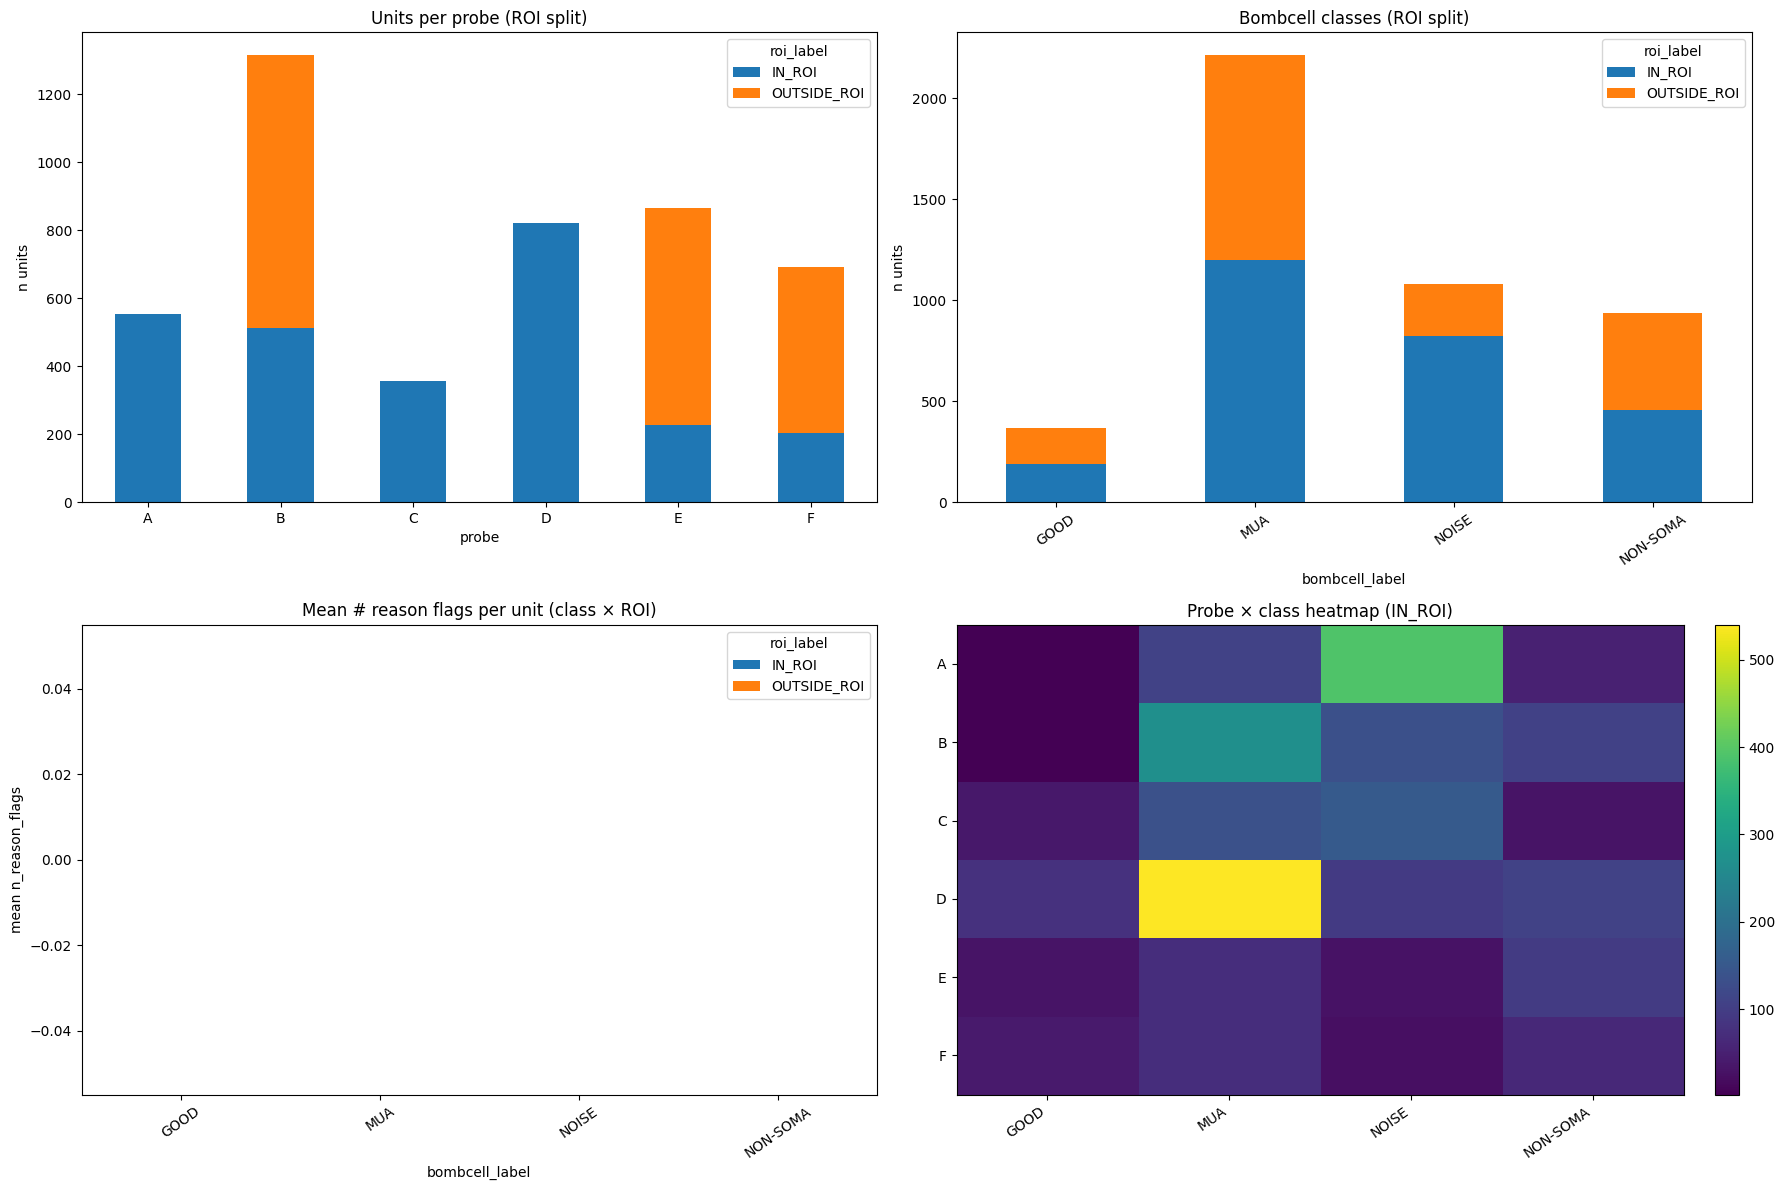

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1) Units per probe split by ROI label
probe_roi = all_df.pivot_table(index='probe', columns='roi_label', values='cluster_id', aggfunc='count', fill_value=0)
probe_roi.plot(kind='bar', stacked=True, ax=axes[0,0])
axes[0,0].set_title('Units per probe (ROI split)')
axes[0,0].set_ylabel('n units')
axes[0,0].tick_params(axis='x', rotation=0)

# 2) Units per class split by ROI label
class_roi = all_df.pivot_table(index='bombcell_label', columns='roi_label', values='cluster_id', aggfunc='count', fill_value=0)
class_roi.plot(kind='bar', stacked=True, ax=axes[0,1])
axes[0,1].set_title('Bombcell classes (ROI split)')
axes[0,1].set_ylabel('n units')
axes[0,1].tick_params(axis='x', rotation=35)

# 3) Mean reason flags per class and ROI
mean_flags = all_df.groupby(['bombcell_label','roi_label'])['n_reason_flags'].mean().unstack(fill_value=0)
mean_flags.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Mean # reason flags per unit (class × ROI)')
axes[1,0].set_ylabel('mean n_reason_flags')
axes[1,0].tick_params(axis='x', rotation=35)

# 4) Probe × class heatmap for IN_ROI only (or fallback ALL)
in_roi = all_df[all_df['roi_label'] == 'IN_ROI']
plot_df = in_roi if len(in_roi) > 0 else all_df
heat = plot_df.pivot_table(index='probe', columns='bombcell_label', values='cluster_id', aggfunc='count', fill_value=0)
im = axes[1,1].imshow(heat.to_numpy(), aspect='auto')
axes[1,1].set_xticks(np.arange(len(heat.columns)))
axes[1,1].set_xticklabels(list(heat.columns), rotation=35, ha='right')
axes[1,1].set_yticks(np.arange(len(heat.index)))
axes[1,1].set_yticklabels(list(heat.index))
axes[1,1].set_title('Probe × class heatmap (' + ('IN_ROI' if len(in_roi)>0 else 'ALL units') + ')')
plt.colorbar(im, ax=axes[1,1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


## Reason-level plots with ROI as a key dimension


In [32]:
from collections import Counter
# import display package for dataframes


# explode reasons for long-form reason table
reason_rows = []
for _, row in all_df.iterrows():
    for r in row['reason_tokens']:
        reason_rows.append({'probe': row['probe'], 'roi_label': row['roi_label'], 'bombcell_label': row['bombcell_label'], 'reason': r})
reason_df = pd.DataFrame(reason_rows)
# display the reason_df 
display(reason_df)
display(all_df)

if len(reason_df) == 0:
    print('No reason flags available in reason_df')
else:
    # top reasons overall
    top_reasons = reason_df['reason'].value_counts().head(12).index
    rr = reason_df[reason_df['reason'].isin(top_reasons)]

    fig, axes = plt.subplots(1, 3, figsize=(23, 6))

    # A) top reasons by ROI
    a = rr.groupby(['reason','roi_label']).size().unstack(fill_value=0).loc[top_reasons]
    a.plot(kind='barh', stacked=True, ax=axes[0])
    axes[0].set_title('Top reason counts (ROI split)')
    axes[0].set_xlabel('count')

    # B) top reasons by probe (stacked)
    b = rr.groupby(['reason','probe']).size().unstack(fill_value=0).loc[top_reasons]
    b.plot(kind='bar', stacked=True, ax=axes[1])
    axes[1].set_title('Top reason counts by probe')
    axes[1].tick_params(axis='x', rotation=60)

    # C) reason heatmap for IN_ROI (or OUTSIDE fallback)
    focus = rr[rr['roi_label']=='IN_ROI']
    if len(focus)==0:
        focus = rr[rr['roi_label']=='OUTSIDE_ROI']
    h = focus.pivot_table(index='reason', columns='probe', values='bombcell_label', aggfunc='count', fill_value=0)
    h = h.loc[h.sum(axis=1).sort_values(ascending=False).head(12).index]
    im = axes[2].imshow(h.to_numpy(), aspect='auto')
    axes[2].set_yticks(np.arange(len(h.index)))
    axes[2].set_yticklabels(list(h.index))
    axes[2].set_xticks(np.arange(len(h.columns)))
    axes[2].set_xticklabels(list(h.columns))
    axes[2].set_title('Reason heatmap in ROI focus set')
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


""


,phy_clusterID,nSpikes,nPeaks,nTroughs,waveformDuration_peakTrough,spatialDecaySlope,waveformBaselineFlatness,scndPeakToTroughRatio,mainPeakToTroughRatio,peak1ToPeak2Ratio,...,probe,ks_dir,save_path,bombcell_label,unit_index,cluster_id,distance_from_tip_um,roi_label,reason_tokens,n_reason_flags
0,0,14579.0,3.0,2.0,933.333333,0.005549,0.511003,0.885923,2.311054,2.608641,...,A,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,NOISE,0,0,30.0,IN_ROI,[],0
1,1,35469.0,3.0,2.0,866.666667,0.005141,0.403423,0.578738,0.578738,0.697073,...,A,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,NOISE,1,1,30.0,IN_ROI,[],0
2,2,176.0,1.0,1.0,700.000000,-0.100000,0.155820,0.272835,6.194461,22.704092,...,A,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,NOISE,2,2,30.0,IN_ROI,[],0
3,3,386.0,1.0,1.0,333.333333,0.008312,0.064297,0.188939,0.188939,0.284326,...,A,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,NOISE,3,3,375.0,IN_ROI,[],0
4,4,10164.0,1.0,1.0,366.666667,0.005716,0.081563,0.311956,0.311956,0.181052,...,A,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,NOISE,4,4,405.0,IN_ROI,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,686,14462.0,1.0,1.0,433.333333,0.010380,0.175306,0.032003,1.915731,59.861500,...,F,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,NON-SOMA,686,686,3700.0,OUTSIDE_ROI,[],0
4596,687,187.0,2.0,1.0,366.666667,0.005940,0.018683,0.124095,0.163694,1.319100,...,F,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,NOISE,687,687,3540.0,OUTSIDE_ROI,[],0
4597,688,1879.0,2.0,1.0,433.333333,0.008648,0.131431,0.339161,0.339161,0.387518,...,F,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,NOISE,688,688,3520.0,OUTSIDE_ROI,[],0
4598,689,949.0,1.0,1.0,200.000000,0.012728,0.035087,0.040457,5.994699,148.172836,...,F,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,H:\Grant\Neuropixels\Kilosort_Recordings\Reach...,NON-SOMA,689,689,3580.0,OUTSIDE_ROI,[],0


No reason flags available in reason_df


## Individual-unit + probe-level drill-down (ROI-aware)


In [33]:
# Pick any probe and class; then inspect units + reason flags
DRILL_PROBE = 'B'
DRILL_CLASS = None  # e.g. 'MUA', 'GOOD', 'NOISE', 'NON-SOMA'; None keeps all
DRILL_ROI = 'IN_ROI'  # IN_ROI | OUTSIDE_ROI | ROI_NOT_SET | None

sub = all_df[all_df['probe'] == DRILL_PROBE].copy()
if DRILL_CLASS is not None:
    sub = sub[sub['bombcell_label'].astype(str).str.contains(DRILL_CLASS, regex=False)]
if DRILL_ROI is not None:
    sub = sub[sub['roi_label'] == DRILL_ROI]

print('n units in drill subset:', len(sub))
display(sub[['probe','cluster_id','bombcell_label','roi_label','distance_from_tip_um','n_reason_flags']].head(100))


n units in drill subset: 512


,probe,cluster_id,bombcell_label,roi_label,distance_from_tip_um,n_reason_flags
554,B,0,MUA,IN_ROI,20.0,0
555,B,1,MUA,IN_ROI,0.0,0
556,B,2,NOISE,IN_ROI,0.0,0
557,B,3,MUA,IN_ROI,0.0,0
558,B,4,GOOD,IN_ROI,20.0,0
...,...,...,...,...,...,...
649,B,95,MUA,IN_ROI,260.0,0
650,B,96,MUA,IN_ROI,240.0,0
651,B,97,GOOD,IN_ROI,240.0,0
652,B,98,MUA,IN_ROI,240.0,0


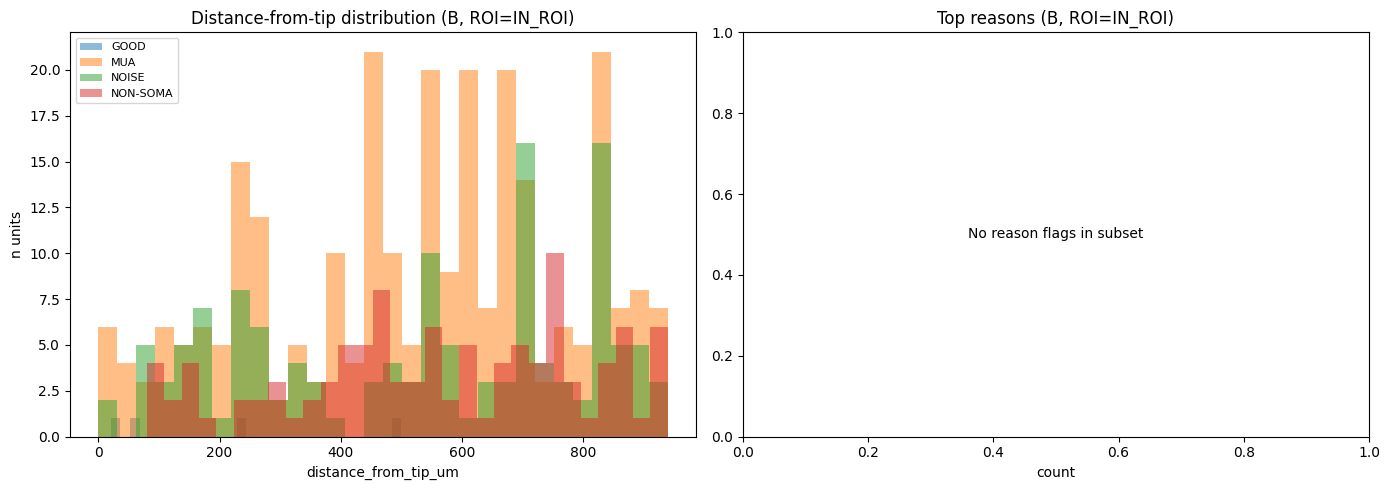

In [34]:
if len(sub) == 0:
    print('Drill subset empty. Adjust DRILL_* filters.')
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # distance distribution by class within drill subset
    if sub['distance_from_tip_um'].notna().any():
        for label, grp in sub.groupby('bombcell_label'):
            vals = grp['distance_from_tip_um'].dropna().to_numpy()
            if len(vals) > 0:
                axes[0].hist(vals, bins=30, alpha=0.5, label=str(label))
        axes[0].set_title(f'Distance-from-tip distribution ({DRILL_PROBE}, ROI={DRILL_ROI})')
        axes[0].set_xlabel('distance_from_tip_um')
        axes[0].set_ylabel('n units')
        axes[0].legend(fontsize=8)
    else:
        axes[0].text(0.5,0.5,'No distance data for this subset',ha='center',va='center')

    # top reasons in drill subset
    from collections import Counter
    c = Counter(r for row in sub['reason_tokens'] for r in row)
    if c:
        top = c.most_common(15)
        labs = [k for k,_ in top][::-1]
        vals = [v for _,v in top][::-1]
        axes[1].barh(labs, vals)
    else:
        axes[1].text(0.5,0.5,'No reason flags in subset',ha='center',va='center')
    axes[1].set_title(f'Top reasons ({DRILL_PROBE}, ROI={DRILL_ROI})')
    axes[1].set_xlabel('count')

    plt.tight_layout()
    plt.show()


## Optional export


In [35]:
out_csv = Path(staging_root) / f'all_probes_{RUN_MODE}_roi_audit.csv'
all_df.to_csv(out_csv, index=False)
print('Saved all-probe ROI-aware dataframe to:', out_csv)


Saved all-probe ROI-aware dataframe to: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\all_probes_batch_roi_audit.csv
